## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)
df.isnull().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [3]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [6]:
y_train = np.log1p(df_train.price.values)
y_val   = np.log1p(df_val.price.values)
y_test  = np.log1p(df_test.price.values)

In [7]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* <b>`room_type`</b>
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

RMSE = mean_squared_error(y_pred, y_val, squared=False)
RMSE

0.46156323035140573

What's the RMSE of this model on validation?

* 0.059
* 0.259
* <b>0.459</b>
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [12]:
scores=[]
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    RMSE = mean_squared_error(y_pred, y_val, squared=False)
    scores.append((n, RMSE))
scores

[(10, 0.4615632303514057),
 (20, 0.4481844037246563),
 (30, 0.445534982591036),
 (40, 0.4436370400686574),
 (50, 0.4423252158693789),
 (60, 0.4416390063083674),
 (70, 0.44124007081450933),
 (80, 0.4411253881867737),
 (90, 0.4405506726295168),
 (100, 0.4399734361245008),
 (110, 0.43947286054175283),
 (120, 0.4392358182874626),
 (130, 0.4393024606141518),
 (140, 0.43900881125883173),
 (150, 0.4389016090216187),
 (160, 0.438700402552987),
 (170, 0.4386273317291687),
 (180, 0.43876507353873545),
 (190, 0.43872322766137933),
 (200, 0.43875047634808284)]

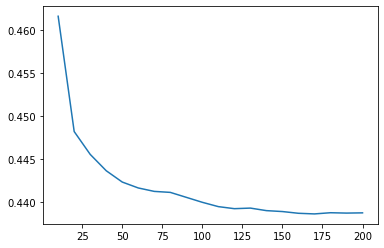

In [13]:
columns = ['n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.RMSE)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- <b>120</b>

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [14]:
scores=[]
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        RMSE = mean_squared_error(y_pred, y_val, squared=False)
        scores.append((d, n, RMSE))
scores

[(10, 10, 0.44555264855924354),
 (10, 20, 0.4420087608705588),
 (10, 30, 0.4413808076445009),
 (10, 40, 0.44147246709402543),
 (10, 50, 0.4410673887594955),
 (10, 60, 0.4410459421233984),
 (10, 70, 0.4407598704010177),
 (10, 80, 0.4405950365838957),
 (10, 90, 0.4403250798157756),
 (10, 100, 0.4401137602802354),
 (10, 110, 0.4400259912335258),
 (10, 120, 0.4398178667293093),
 (10, 130, 0.4398547755113232),
 (10, 140, 0.43984985853331104),
 (10, 150, 0.4396900165901451),
 (10, 160, 0.4396442598915558),
 (10, 170, 0.43962394971115537),
 (10, 180, 0.4397169310258638),
 (10, 190, 0.4396683937380781),
 (10, 200, 0.43967858051302805),
 (15, 10, 0.45014955224590053),
 (15, 20, 0.4413965306029092),
 (15, 30, 0.43989426444119967),
 (15, 40, 0.4392847552663334),
 (15, 50, 0.43835155877923293),
 (15, 60, 0.4379833031193405),
 (15, 70, 0.43745781237443004),
 (15, 80, 0.43726812528767756),
 (15, 90, 0.4368731254920105),
 (15, 100, 0.43651230928156826),
 (15, 110, 0.43628106735528754),
 (15, 120, 0.4

In [15]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)

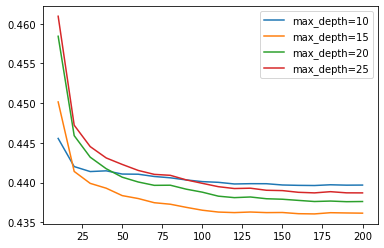

In [16]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE, label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* <b>15</b>
* 20
* 25

In [17]:
scores=[]
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=20, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        RMSE = mean_squared_error(y_pred, y_val, squared=False)
        scores.append((d, n, RMSE))

In [18]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)

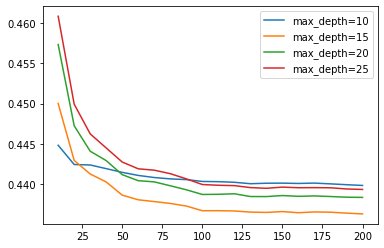

In [19]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE, label='max_depth=%d' % d)

plt.legend()

Bonus question (not graded):
Will the answer be different if we change the seed for the model?

#### Answer: No there is no change after changing the seed from 1 to 20.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [20]:
dt = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
dt.fit(X_train, y_train)
importance = dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('%s, Score: %.5f' % (dv.get_feature_names()[i],v))

availability_365, Score: 0.07626
calculated_host_listings_count, Score: 0.03010
latitude, Score: 0.15278
longitude, Score: 0.15410
minimum_nights, Score: 0.05325
neighbourhood_group=Bronx, Score: 0.00026
neighbourhood_group=Brooklyn, Score: 0.00097
neighbourhood_group=Manhattan, Score: 0.03405
neighbourhood_group=Queens, Score: 0.00117
neighbourhood_group=Staten Island, Score: 0.00008
number_of_reviews, Score: 0.04159
reviews_per_month, Score: 0.05443
room_type=Entire home/apt, Score: 0.39190
room_type=Private room, Score: 0.00403
room_type=Shared room, Score: 0.00502


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* <b>`room_type=Entire home/apt`</b>	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [21]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [22]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [23]:
%%capture output1
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model1 = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

In [24]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


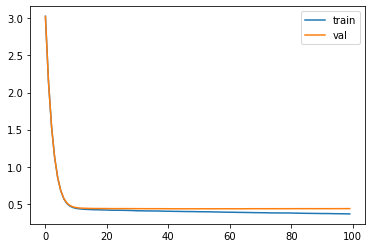

In [25]:
df_score1 = parse_xgb_output(output1)
plt.plot(df_score1.num_iter, df_score1.train_auc, label='train')
plt.plot(df_score1.num_iter, df_score1.val_auc, label='val')
plt.legend()

Now change `eta` first to `0.1` and then to `0.01`

In [26]:
%%capture output2
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model2 = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

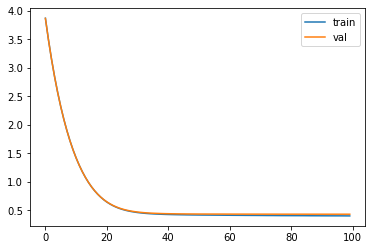

In [27]:
df_score2 = parse_xgb_output(output2)
plt.plot(df_score2.num_iter, df_score2.train_auc, label='train')
plt.plot(df_score2.num_iter, df_score2.val_auc, label='val')
plt.legend()

In [28]:
%%capture output3
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model3 = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

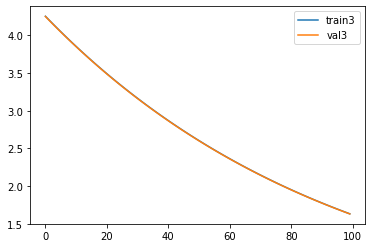

In [29]:
df_score3 = parse_xgb_output(output3)
plt.plot(df_score3.num_iter, df_score3.train_auc, label='train3')
plt.plot(df_score3.num_iter, df_score3.val_auc, label='val3')
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* <b>0.3</b>
* 0.1
* 0.01

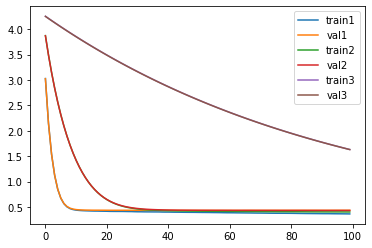

In [30]:
plt.plot(df_score1.num_iter, df_score1.train_auc, label='train1')
plt.plot(df_score1.num_iter, df_score1.val_auc, label='val1')
plt.plot(df_score2.num_iter, df_score2.train_auc, label='train2')
plt.plot(df_score2.num_iter, df_score2.val_auc, label='val2')
plt.plot(df_score3.num_iter, df_score3.train_auc, label='train3')
plt.plot(df_score3.num_iter, df_score3.val_auc, label='val3')
plt.legend()